# Experimenting with possible approaches

In [46]:
!pip install -r ../requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.4/125.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 5.5 MB/s eta 0:00:00


## Imports

In [47]:
import numpy as np
import pandas as pd
import pymc as pm
import geopy

## 1. Data compilation

In [23]:
# assumptions
# source - https://www.icaew.com/insights/viewpoints-on-the-news/2022/sept-2022/chart-of-the-week-energy-price-cap-update
GAS_PRICE_PER_KWH = 3.3
ELECTRIC_PRICE_PER_KWH = 19.0 

In [4]:
# look at the headline dataset of consumption by LSOA
main_data = pd.read_csv("../data/raw/LSOA Energy Consumption Data.csv")

In [7]:
main_data.shape

(33811, 21)

In [8]:
main_data['Lower Layer Super Output Area (LSOA) Code'].nunique()

33811

In [11]:
# look at household size data
household_size = pd.read_csv("../data/raw/RM202-Household-Size-By-Number-Of-Rooms-2021-lsoa-ONS.csv")

In [15]:
household_size["Number of rooms (Valuation Office Agency) (6 categories) Code"].unique()

array([1, 2, 3, 4, 5, 6])

In [18]:
household_size[household_size["Number of rooms (Valuation Office Agency) (6 categories) Code"] == 4]["Household size (5 categories) Code"].unique()

array([0, 1, 2, 3, 4])

In [17]:
building_age = pd.read_csv("../data/raw/CTSOP_4_1_2021.csv")

In [62]:
# Library to work with netCDF files
from netCDF4 import Dataset

file_name = "../data/raw/tas_hadukgrid_uk_60km_ann_202101-202112.nc"
file_id = Dataset(file_name)

latitude = file_id.variables["latitude"][:,:]
longitude = file_id.variables["longitude"][:,:]
temps = file_id.variables["tas"][:,:]

lats = [np.mean(x) for x in latitude]
longs = [np.mean(x) for x in longitude] 
ts = [np.mean(x) for x in temps[0]]
temp_data = pd.DataFrame({"latitude": lats,
                          "longitude": longs,
                          "temperature": ts}
                        )

temp_data = temp_data[temp_data.temperature > 0]

### Combining and generating features

In [49]:
# feature generation
main_data["pct_electric"] = main_data['Electricity Consumption (kWh)'] / main_data['Total Energy Consumption (kWh)']
main_data["coords"] = [(lat, long) for lat, long in zip(main_data.Latitude, main_data.Longitude)]

In [50]:
df = main_data[['Local Authority Name', 'Local Authority Code', 'MSOA Name',
       'Middle Layer Super Output Area (MSOA) Code', 'LSOA Name',
       'Lower Layer Super Output Area (LSOA) Code', 'coords',
       'pct_electric', 'Average Energy Consumption per Person (kWh)']]

In [51]:
df.columns = ['LA_name', 'LA', 'MSOA_ame',
       'MSOA', 'LSOA_name',
       'LSOA', 'coords',
       'pct_electric', 'energy_consumption_per_person']

In [78]:
# add temperature data
coords =  [(lat, long) for lat, long in zip(temp_data.latitude, temp_data.longitude)]
temp_dict = {co:t for co,t in zip(coords, temp_data.temperature)}

def find_closest_temp_measurement(this_point):
    return temp_dict[min(temp_dict.keys(), key=lambda x: geopy.distance.geodesic(this_point, x))]

df["temperature"] = [find_closest_temp_measurement(x) for x in df.coords]

/tmp/ipykernel_1327/1322134421.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["temperature"] = [find_closest_temp_measurement(x) for x in df.coords]


In [82]:
# compute energy cost
df["energy_cost"] = [ELECTRIC_PRICE_PER_KWH * x + GAS_PRICE_PER_KWH * (1-x) for x in df["pct_electric"]]

/tmp/ipykernel_1327/605917991.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["energy_cost"] = [ELECTRIC_PRICE_PER_KWH * x + GAS_PRICE_PER_KWH * (1-x) for x in df["pct_electric"]]


In [88]:
# add income data
income_data = pd.read_csv("../data/raw/net_income_after_housing_costs.csv")
income_data = income_data[["MSOA code", "Net annual income after housing costs (£)"]].copy()
income_data.columns = ["MSOA", "net_income"]
df = df.merge(income_data, on="MSOA", how="left")

In [108]:
df.shape

(33811, 12)

In [109]:
# add green data
voting_data = pd.read_csv("../data/raw/CBP09228_detailed_results_England_elections.csv")
voting_data["pct_green"] = voting_data["Green"] / voting_data["Total"]
voting_data["green_council"] = voting_data["pct_green"] >= 0.1
voting_data = voting_data[["ONS code", "green_council"]].copy()
voting_data.columns = ["LA", "politically_green"]
df = df.merge(voting_data, on="LA", how="left")

In [110]:
df.shape

(33811, 13)

<Axes: >

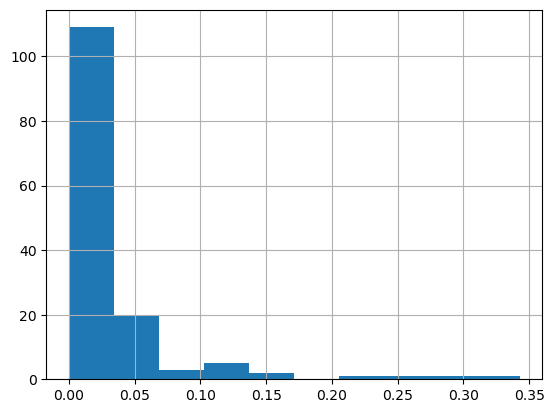

In [100]:
voting_data["pct_green"].hist()

In [91]:
voting_data

,Unnamed: 0,Local authority,ONS code,Class of authority,Unnamed: 4,Unnamed: 5,Conservative,Labour,Liberal Democrat,Green,...,Liberal Democrat.1,Green.1,Others/independent.1,Unnamed: 19,Conservative.2,Labour.2,Liberal Democrat.2,Green.2,Others/independent.2,Unnamed: 25
0,NaN,Adur,E07000223,Shire district,N,2016.0,19,7,0,1,...,0%,3%,7%,NaN,3,0,0,1,-4,NaN
1,NaN,Amber Valley,E07000032,Shire district,N,2016.0,28,16,0,1,...,0%,2%,0%,NaN,9,-9,0,0,0,NaN
2,NaN,Barnsley,E08000016,Metropolitan district,N,2016.0,3,49,7,0,...,11%,0%,6%,NaN,0,-1,3,0,-2,NaN
3,NaN,Basildon,E07000066,Shire district,N,2016.0,22,12,0,0,...,0%,0%,19%,NaN,4,-2,0,0,-2,NaN
4,NaN,Basingstoke & Deane,E07000084,Shire district,Y,NaN,33,10,5,0,...,9%,0%,11%,NaN,4,-8,-2,0,6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138,NaN,Wokingham,E06000041,Unitary authority,N,2016.0,31,3,18,0,...,33%,0%,4%,NaN,-2,-1,3,0,0,NaN
139,NaN,Wolverhampton,E08000031,Metropolitan district,N,2016.0,15,44,0,0,...,0%,0%,2%,NaN,5,-5,0,0,0,NaN
140,NaN,Worcester,E07000237,Shire district,N,2016.0,18,11,2,4,...,6%,11%,0%,NaN,2,-4,1,1,0,NaN
141,NaN,Worcestershire,E10000034,County,N,2017.0,45,3,4,3,...,7%,5%,4%,NaN,5,-7,1,1,0,NaN


,MSOA code,MSOA name,Local authority code,Local authority name,Region code,Region name,Net annual income after housing costs (£),Upper confidence limit (£),Lower confidence limit (£),Confidence interval (£)
0,E02004297,County Durham 001,E06000047,County Durham,E12000001,North East,"27,700","31,200","24,600","6,600"
1,E02004290,County Durham 002,E06000047,County Durham,E12000001,North East,"28,600","32,400","25,300","7,100"
2,E02004298,County Durham 003,E06000047,County Durham,E12000001,North East,"31,400","35,400","27,800","7,600"
3,E02004299,County Durham 004,E06000047,County Durham,E12000001,North East,"25,000","28,200","22,100","6,100"
4,E02004291,County Durham 005,E06000047,County Durham,E12000001,North East,"23,800","26,900","21,000","5,900"
...,...,...,...,...,...,...,...,...,...,...
7196,W02000362,Newport 016,W06000022,Newport,W92000004,Wales,"29,300","33,100","26,000","7,100"
7197,W02000363,Newport 017,W06000022,Newport,W92000004,Wales,"24,000","27,100","21,300","5,800"
7198,W02000364,Newport 018,W06000022,Newport,W92000004,Wales,"20,300","23,200","17,900","5,300"
7199,W02000365,Newport 019,W06000022,Newport,W92000004,Wales,"21,700","24,600","19,100","5,500"


## 2. Analysis

## 3. Modelling